In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark
import seaborn as sns
import matplotlib.pyplot as plt


location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("Houses Price") \
    .getOrCreate()

In [2]:
# Carichiamo il data set
trainDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/train.csv', header = 'True', inferSchema='True', nullValue='NA')
testDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/test.csv', header = 'True', inferSchema='True', nullValue='NA')

In [3]:
trainDF.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [4]:
# creo un UDF per contare il numero di elementi nulli all'interno del dataframe divisi per colonna

from pyspark.sql.functions import col

def null_value_count(df):
  null_columns_counts = []
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [9]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                      PoolQC| 1453|
|                 MiscFeature| 1406|
|                       Alley| 1369|
|                       Fence| 1179|
|                 FireplaceQu|  690|
|                 LotFrontage|  259|
|                 GarageYrBlt|   81|
|                  GarageType|   81|
|                GarageFinish|   81|
|                  GarageQual|   81|
|                  GarageCond|   81|
|                BsmtFinType2|   38|
|                BsmtExposure|   38|
|                    BsmtCond|   37|
|                BsmtFinType1|   37|
|                    BsmtQual|   37|
|                  MasVnrType|    8|
|                  MasVnrArea|    8|
|                  Electrical|    1|
+----------------------------+-----+



In [10]:
# calcolo la percentuale di dati mancanti

nullFeaturesTrainDF = nullFeaturesTrainDF.withColumn( "Missing Ratio",  col("Count") / trainDF.count() * 100)
nullFeaturesTrainDF.show()

+----------------------------+-----+------------------+
|TRAIN Features with NA value|Count|     Missing Ratio|
+----------------------------+-----+------------------+
|                      PoolQC| 1453| 99.52054794520548|
|                 MiscFeature| 1406| 96.30136986301369|
|                       Alley| 1369| 93.76712328767123|
|                       Fence| 1179| 80.75342465753424|
|                 FireplaceQu|  690| 47.26027397260274|
|                 LotFrontage|  259| 17.73972602739726|
|                 GarageYrBlt|   81|5.5479452054794525|
|                GarageFinish|   81|5.5479452054794525|
|                  GarageQual|   81|5.5479452054794525|
|                  GarageType|   81|5.5479452054794525|
|                  GarageCond|   81|5.5479452054794525|
|                BsmtFinType2|   38|2.6027397260273974|
|                BsmtExposure|   38|2.6027397260273974|
|                    BsmtQual|   37|2.5342465753424657|
|                BsmtFinType1|   37|2.5342465753

Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

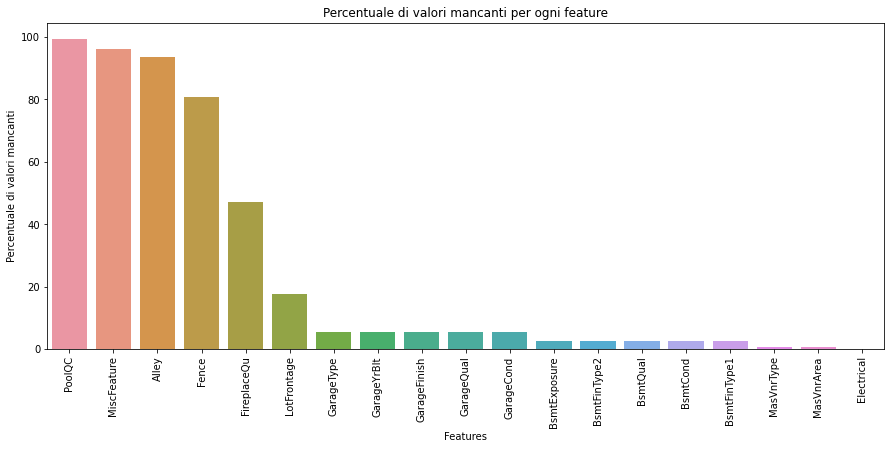

In [12]:
# facciamo un grafico per capire meglio
df_TrainPD = nullFeaturesTrainDF.toPandas()

plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=df_TrainPD['TRAIN Features with NA value'], y=df_TrainPD['Missing Ratio']) 
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [15]:
# cancelliamo le features che hanno una percentuale di valori nulli sopra 80%
dropFeatures = df_TrainPD['TRAIN Features with NA value'][ df_TrainPD['Missing Ratio'] > 80 ] 
print(f'Lista delle features da cancellare:\n{dropFeatures}')

trainDF = trainDF.drop(*dropFeatures)

Lista delle features da cancellare:
0         PoolQC
1    MiscFeature
2          Alley
3          Fence
Name: TRAIN Features with NA value, dtype: object


In [16]:
#cancelliamo le feature droppate anche nel test set
train_cols = list(trainDF.columns)
train_cols.remove('SalePrice')

testDF = testDF[train_cols]

In [18]:
# controlliamo le feature mancanti anche nel test set
nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                FireplaceQu|  730|
|                LotFrontage|  227|
|                 GarageQual|   78|
|                 GarageCond|   78|
|               GarageFinish|   78|
|                GarageYrBlt|   78|
|                 GarageType|   76|
|                   BsmtCond|   45|
|               BsmtExposure|   44|
|                   BsmtQual|   44|
|               BsmtFinType1|   42|
|               BsmtFinType2|   42|
|                 MasVnrType|   16|
|                 MasVnrArea|   15|
|                   MSZoning|    4|
|               BsmtFullBath|    2|
|               BsmtHalfBath|    2|
|                  Utilities|    2|
|                 Functional|    2|
|                Exterior1st|    1|
+---------------------------+-----+
only showing top 20 rows



In [19]:
# settiamo la feature FireplaceQu = 'None' in tutte le righe che hanno Fireplaces = 0

trainDF = trainDF.where( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ) ).fillna('None', subset=['FireplaceQu'])

nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                 LotFrontage|   90|
|                  GarageQual|   72|
|                  GarageCond|   72|
|                GarageFinish|   72|
|                  GarageType|   72|
|                 GarageYrBlt|   72|
|                BsmtExposure|   28|
|                BsmtFinType2|   28|
|                BsmtFinType1|   28|
|                    BsmtQual|   28|
|                    BsmtCond|   28|
|                  MasVnrType|    4|
|                  MasVnrArea|    4|
|                  Electrical|    1|
+----------------------------+-----+



In [20]:
# ripetiamo l'operazione anche per il test set

testDF = testDF.where( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ) ).fillna('None', subset=['FireplaceQu'])

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                LotFrontage|   86|
|                GarageYrBlt|   72|
|                 GarageQual|   72|
|               GarageFinish|   72|
|                 GarageCond|   72|
|                 GarageType|   70|
|                   BsmtQual|   34|
|               BsmtExposure|   33|
|                   BsmtCond|   32|
|               BsmtFinType1|   32|
|               BsmtFinType2|   32|
|                 MasVnrType|    6|
|                 MasVnrArea|    5|
|                   MSZoning|    4|
|                 Functional|    2|
|                KitchenQual|    1|
|                 GarageCars|    1|
|               BsmtHalfBath|    1|
|                 GarageArea|    1|
|                 BsmtFinSF1|    1|
+---------------------------+-----+
only showing top 20 rows



In [ ]:
# Notiamo che i valori mancanti nelle features GarageType, GarageYrBlt, GarageQual, GarageFinish, GarageCond sono uguali.
# Controlliamo quanti garage mancano


features = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']

print(f"Numero di righe che hanno GarageArea a 0: {trainDF.filter( trainDF['GarageArea'] == 0 ).count()}")
print(f"Numero di righe che hanno GarageCars a 0: {trainDF.filter( trainDF['GarageCars'] == 0 ).count()}")

In [ ]:
testDF.select("GarageType").distinct().show()
testDF.select("GarageYrBlt").distinct().show()
testDF.select("GarageFinish").distinct().show()
testDF.select("GarageQual").distinct().show()
testDF.select("GarageCond").distinct().show()


In [ ]:
plt.figure(figsize=(15, 12), dpi = 600) 
corr = df.corr()
sns.heatmap(corr, annot=True, annot_kws={"fontsize":4}, square=True).set_title('Features Correlating', fontdict={'fontsize':16}, pad=16);

In [ ]:
# vediamo la correlazione solo con il prezzo di vendita

corrSP = df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(2, 4), dpi = 200) 
sns.set(font_scale = 0.4)

sns.heatmap(corrSP, annot=True, annot_kws={"fontsize":4},).set_title('Features Correlating with Sales Price', fontdict={'fontsize':10}, pad=16);

In [ ]:
# prendiamo le feature che hanno un valore di correlazione >= 0.5 ed eliminiamo la colonna SalePrice che avrà valore 1 
featuresSelect = corrSP['SalePrice'][ corrSP['SalePrice'] >= 0.5].drop('SalePrice')

print(featuresSelect)